In [1]:
!pip install numdifftools
!pip install astropy
!pip install camb

import numpy as np
import pandas as pd
import astropy as ap
import matplotlib.pyplot as plt
import camb
from scipy.integrate import quad
from scipy.optimize import curve_fit, minimize, approx_fprime
from matplotlib.patches import Ellipse
import numdifftools as nd
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.cosmology import FlatLambdaCDM, FlatwCDM, Flatw0waCDM
from camb import model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.8 MB/s eta 0:00:00


/tmp/ipython-input-377600960.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf = V_z / np.trapz(V_z, z_grid)  # normalized p(z), trapz integrates using composite trapezoidal rule


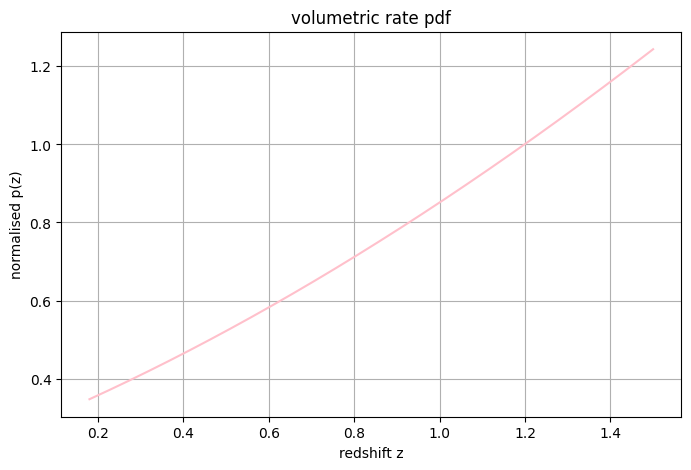

In [2]:
# first begin with simulating the 'truth'

# z values follow a volumetric rate for simulated SN

z_grid = np.linspace(0.18, 1.5, 10000)
V_z = 2.278e-5 * (1 + z_grid)**1.7  # rate as a function of z
pdf = V_z / np.trapz(V_z, z_grid)  # normalized p(z), trapz integrates using composite trapezoidal rule

# visualising pdf
plt.figure(figsize=(8,5))
plt.plot(z_grid, pdf, color = 'pink')
plt.xlabel('redshift z')
plt.ylabel('normalised p(z)')
plt.title('volumetric rate pdf')
plt.grid()
plt.show()

100000


(array([  15.,   84.,  281.,  718., 1011., 1171., 1285., 1295., 1311.,
        1411., 1391., 1392., 1528., 1600., 1718., 1732., 1765., 1804.,
        1900., 1994., 2073., 2058., 2201., 2186., 2303., 2407., 2435.,
        2535., 2522., 2516., 2696., 2718., 2786., 2922., 2996., 2887.,
        3025., 3205., 3309., 3302., 3469., 3475., 3456., 3586., 3292.,
        2431., 1305.,  410.,   76.,   12.]),
 array([0.07908996, 0.10996257, 0.14083519, 0.1717078 , 0.20258042,
        0.23345303, 0.26432565, 0.29519826, 0.32607088, 0.35694349,
        0.38781611, 0.41868872, 0.44956134, 0.48043395, 0.51130657,
        0.54217918, 0.5730518 , 0.60392441, 0.63479703, 0.66566964,
        0.69654226, 0.72741487, 0.75828749, 0.7891601 , 0.82003272,
        0.85090533, 0.88177795, 0.91265056, 0.94352318, 0.9743958 ,
        1.00526841, 1.03614103, 1.06701364, 1.09788626, 1.12875887,
        1.15963149, 1.1905041 , 1.22137672, 1.25224933, 1.28312195,
        1.31399456, 1.34486718, 1.37573979, 1.40661241, 

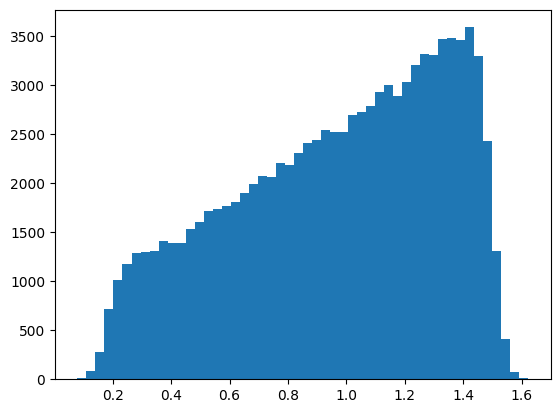

In [3]:
# sampling values from distribution
N = 100000
u = np.random.uniform(0, 1, N)
cdf = np.cumsum(pdf)
cdf /= cdf[-1]
z_sample = np.interp(u, cdf, z_grid)

# fit kde and create a new sample
kde = gaussian_kde(z_sample)

# making sure there are no negative z sample values
sampled_z = kde.resample(N).flatten()
sampled_z = np.abs(sampled_z)
print(len(sampled_z))
plt.hist(sampled_z, bins=50)

<class 'numpy.ndarray'>


(array([1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 8.000e+00, 9.000e+00,
        1.400e+01, 2.400e+01, 4.300e+01, 6.000e+01, 8.600e+01, 1.490e+02,
        2.240e+02, 2.820e+02, 3.570e+02, 4.180e+02, 4.900e+02, 5.520e+02,
        6.110e+02, 6.830e+02, 7.390e+02, 7.870e+02, 8.000e+02, 8.880e+02,
        9.920e+02, 1.006e+03, 1.093e+03, 1.149e+03, 1.336e+03, 1.459e+03,
        1.673e+03, 1.778e+03, 1.925e+03, 2.085e+03, 2.370e+03, 2.688e+03,
        2.786e+03, 3.177e+03, 3.552e+03, 4.001e+03, 4.406e+03, 4.746e+03,
        5.322e+03, 6.077e+03, 6.585e+03, 7.637e+03, 8.498e+03, 9.417e+03,
        6.504e+03, 5.070e+02]),
 array([37.8205129 , 37.97049629, 38.12047968, 38.27046307, 38.42044647,
        38.57042986, 38.72041325, 38.87039664, 39.02038004, 39.17036343,
        39.32034682, 39.47033021, 39.6203136 , 39.770297  , 39.92028039,
        40.07026378, 40.22024717, 40.37023057, 40.52021396, 40.67019735,
        40.82018074, 40.97016413, 41.12014753, 41.27013092, 41.42011431,
        41.

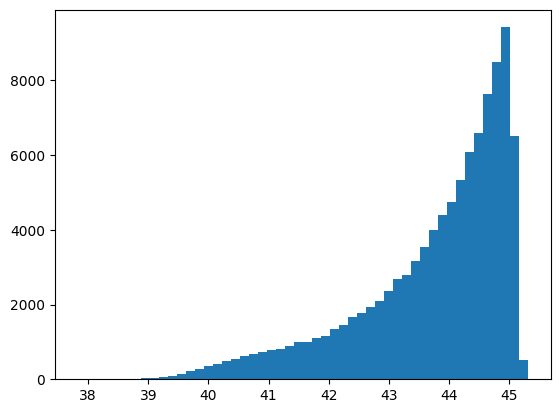

In [4]:
# next we find mu values from this sampled z
cosmo = Flatw0waCDM(H0=67, Om0=0.495, w0=-0.36, wa=-8.8) # importing cosmology
mu_sim = cosmo.distmod(sampled_z).value
print(type(mu_sim))
plt.hist(mu_sim, bins = 50)

Mounted at /content/drive


(array([ 7.,  6., 12., 12., 12., 31., 32., 27., 37., 43., 47., 87., 67.,
        43., 47., 44., 59., 68., 47., 59., 66., 71., 71., 64., 68., 58.,
        57., 49., 70., 29., 32., 31., 22., 27., 17., 20., 15., 16., 10.,
         8.,  9.,  4.,  7.,  4.,  4.,  7.,  5.,  1.,  2.,  1.]),
 array([0.10442 , 0.124758, 0.145096, 0.165434, 0.185772, 0.20611 ,
        0.226448, 0.246786, 0.267124, 0.287462, 0.3078  , 0.328138,
        0.348476, 0.368814, 0.389152, 0.40949 , 0.429828, 0.450166,
        0.470504, 0.490842, 0.51118 , 0.531518, 0.551856, 0.572194,
        0.592532, 0.61287 , 0.633208, 0.653546, 0.673884, 0.694222,
        0.71456 , 0.734898, 0.755236, 0.775574, 0.795912, 0.81625 ,
        0.836588, 0.856926, 0.877264, 0.897602, 0.91794 , 0.938278,
        0.958616, 0.978954, 0.999292, 1.01963 , 1.039968, 1.060306,
        1.080644, 1.100982, 1.12132 ]),
 <BarContainer object of 50 artists>)

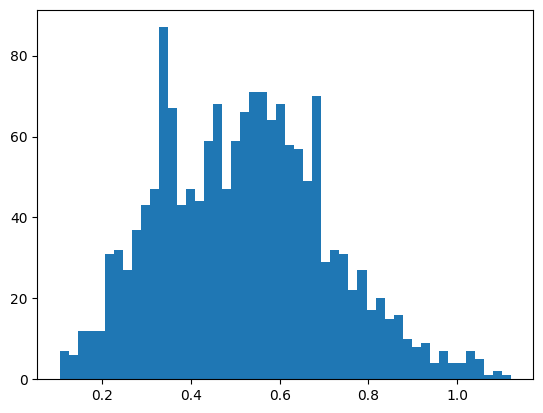

In [5]:
# mount drive
from google.colab import drive
drive.mount("/content/drive")

# using real z data
csv_data = '/content/drive/MyDrive/2024project/DES-SN5YR_HD.csv'
df = pd.read_csv(csv_data)
z_obs = df['zHD']

mu_obs = df['MU']
sys_data = np.loadtxt('/content/drive/MyDrive/2024project/STAT+SYS_new.txt')
mu_error = df['MUERR_FINAL']

z_obs = z_obs[z_obs > 0.1]
plt.hist(z_obs, bins=50)

(array([  1.,   0.,   0.,   3.,   4.,  12.,  31.,  44.,  72.,  62.,  78.,
        100., 100., 105., 116., 110., 102.,  89.,  85.,  97.,  71.,  71.,
         76.,  49.,  36.,  35.,  32.,  25.,  25.,  22.,  18.,  13.,   6.,
          5.,   8.,   7.,   5.,   2.,   8.,   2.,   2.,   2.,   1.,   2.,
          1.,   2.,   0.,   1.,   0.,   1.]),
 array([0.0466  , 0.053632, 0.060664, 0.067696, 0.074728, 0.08176 ,
        0.088792, 0.095824, 0.102856, 0.109888, 0.11692 , 0.123952,
        0.130984, 0.138016, 0.145048, 0.15208 , 0.159112, 0.166144,
        0.173176, 0.180208, 0.18724 , 0.194272, 0.201304, 0.208336,
        0.215368, 0.2224  , 0.229432, 0.236464, 0.243496, 0.250528,
        0.25756 , 0.264592, 0.271624, 0.278656, 0.285688, 0.29272 ,
        0.299752, 0.306784, 0.313816, 0.320848, 0.32788 , 0.334912,
        0.341944, 0.348976, 0.356008, 0.36304 , 0.370072, 0.377104,
        0.384136, 0.391168, 0.3982  ]),
 <BarContainer object of 50 artists>)

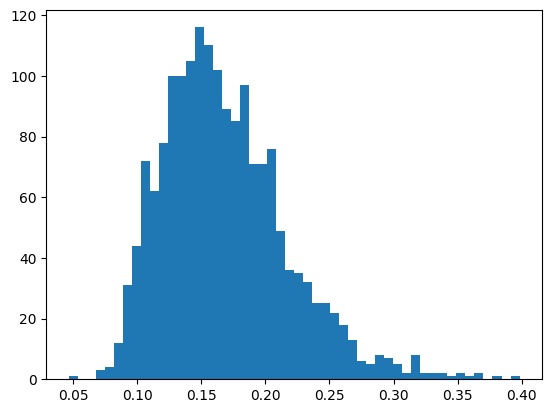

In [6]:
cut_muerr = mu_error[mu_error < 0.4] # separating the bulk of muerr values from the anomalies
plt.hist(cut_muerr, bins = 50)

(array([1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 8.000e+00, 1.200e+01,
        1.700e+01, 3.000e+01, 3.900e+01, 6.700e+01, 1.000e+02, 1.670e+02,
        2.400e+02, 3.040e+02, 3.670e+02, 4.760e+02, 4.960e+02, 5.560e+02,
        6.520e+02, 7.170e+02, 7.540e+02, 8.120e+02, 8.220e+02, 9.320e+02,
        9.770e+02, 1.102e+03, 1.121e+03, 1.181e+03, 1.450e+03, 1.575e+03,
        1.726e+03, 1.833e+03, 2.005e+03, 2.265e+03, 2.554e+03, 2.772e+03,
        3.027e+03, 3.417e+03, 3.867e+03, 4.142e+03, 4.674e+03, 5.085e+03,
        5.831e+03, 6.500e+03, 7.224e+03, 8.286e+03, 9.123e+03, 8.296e+03,
        2.292e+03, 1.000e+02]),
 array([38.00142044, 38.15310773, 38.30479501, 38.45648229, 38.60816957,
        38.75985685, 38.91154413, 39.06323142, 39.2149187 , 39.36660598,
        39.51829326, 39.66998054, 39.82166782, 39.97335511, 40.12504239,
        40.27672967, 40.42841695, 40.58010423, 40.73179151, 40.8834788 ,
        41.03516608, 41.18685336, 41.33854064, 41.49022792, 41.64191521,
        41.

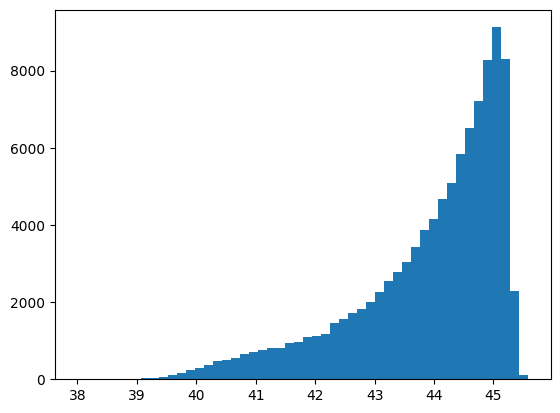

In [7]:
# finding a muerr (no longer using real distribution, simulating a fake one)

# creating kde
kde_cutmuerr = gaussian_kde(cut_muerr) # gives the pdf of the cut muerr
cutmuerr_sim = kde_cutmuerr.resample(N).flatten() # creates a sample
noise1 = np.random.normal(0, cutmuerr_sim) # drawing noise

# adding noise/ muerr to the mu vals
mu_obs_sim = mu_sim + cutmuerr_sim
plt.hist(mu_obs_sim, bins = 50)

In [8]:
print(type(mu_obs_sim))
print(len(mu_obs_sim))
print(len(mu_sim))

<class 'numpy.ndarray'>
100000
100000


In [9]:
from astropy.cosmology import Planck18 as planck
mu_07 = planck.distmod(0.7).value
m_07 = mu_07 -19.3 # appaz mag at z=0.7
print(m_07)

23.90966727510325


In [10]:
# computing apparent magnitudes

abs_mag_true = -19.3

appaz_mag = mu_obs_sim - 19.3

# using logistic function

def logistic_efficiency(mag, m50, k):
    """
    Logistic detection efficiency function.
    - m50: magnitude where detection efficiency is 50%
    - k: steepness of the drop-off (higher number = more steep)
    """
    return 1 / (1 + np.exp(k * (mag - m50)))

efficiency_vec = logistic_efficiency(appaz_mag, m50=25, k=4.5)

mask = np.random.rand(len(appaz_mag)) < efficiency_vec

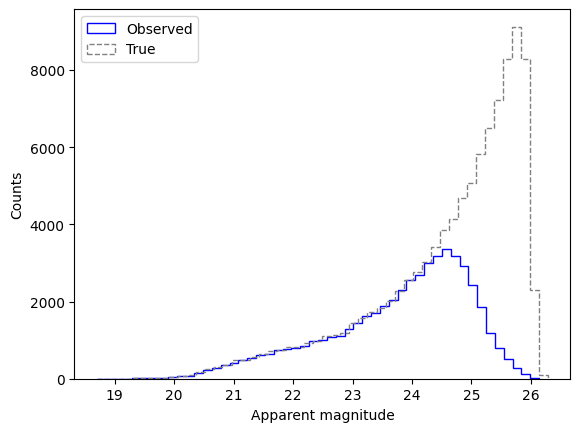

In [11]:
# apply selec function
appaz_mag_obs = appaz_mag[mask]

# plot
plt.hist(appaz_mag_obs, bins=50, histtype='step', color='blue', label='Observed')
plt.hist(appaz_mag, bins=50, histtype='step', color='gray', linestyle='--', label='True')
plt.xlabel('Apparent magnitude')
plt.ylabel('Counts')
plt.legend()
plt.show()

51690


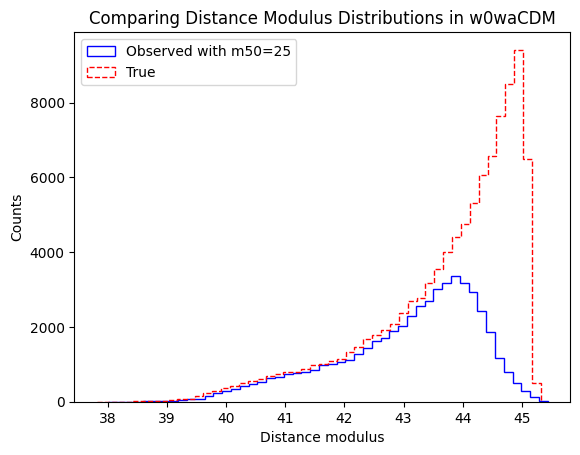

In [12]:
z_sim_selected = sampled_z[mask]
print(len(z_sim_selected))
#plt.hist(z_sim_selected, bins = 50)

# apply mask onto mu_obs (not mu_sim)
mu_obs_selected = mu_obs_sim[mask]
plt.hist(mu_obs_selected, bins = 50, histtype='step', color='blue', label='Observed with m50=25')
plt.hist(mu_sim, bins = 50, histtype='step', color='red', linestyle='--', label='True')
plt.xlabel('Distance modulus')
plt.ylabel('Counts')
plt.title("Comparing Distance Modulus Distributions in w0waCDM")
plt.legend()
plt.show()

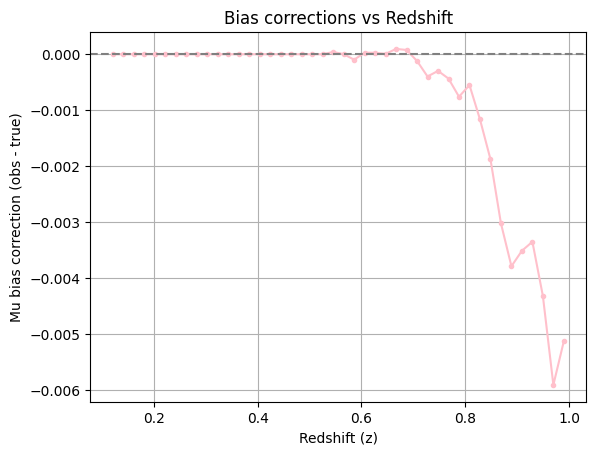

In [13]:
# finding bias corrections now

# creating redshift bins so there's a few hundred vals in each

bins = np.linspace(0.01, 1, 50)
bin_indices = np.digitize(z_sim_selected, bins) # assigns each redshift to a bin

# initialising empty lists to store values
bias_vals = [] # bias correction for each bin
z_bin_centres = [] #

for i in range(1, len(bins)): # loop over each redshift bin
    # bin limits
    z_lo, z_hi = bins[i-1], bins[i] # defines the redshift range in each bin

    # mask for selected/ obs SN in this redshift bin
    in_bin_obs = (z_sim_selected >= z_lo) & (z_sim_selected < z_hi) # mask that selects observed supernovae within that redshift bin
    mu_obs_bin = mu_obs_selected[in_bin_obs] # applying mask

    # mask for full (true) sample in the same redshift bin
    in_bin_true = (sampled_z >= z_lo) & (sampled_z < z_hi) # mask that selects true supernovae within redshift bin
    mu_true_bin = mu_obs_sim[in_bin_true] # applying mask

    if len(mu_obs_bin) > 35 and len(mu_true_bin) > 35: # just to ensure bin has data in it before computing
        bias = np.mean(mu_obs_bin) - np.mean(mu_true_bin) # bias = obs - true
        bias_vals.append(bias)
        z_bin_centres.append((z_lo + z_hi) / 2) # to find the bin centre

    """
  Expecting the graph to get more negative at higher z values
  For brighter SN, the distance modulus is lower
  Then if we have Malmquist bias at high z, the avg for mu_obs_sim should be lower than avg for mu_true_sim
    """

# plotting
plt.plot(z_bin_centres, bias_vals, marker='.', color = 'pink') # plotting the bias values
# plt.axhline(0, color='pink', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Mu bias correction (obs - true)')
plt.title('Bias corrections vs Redshift')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

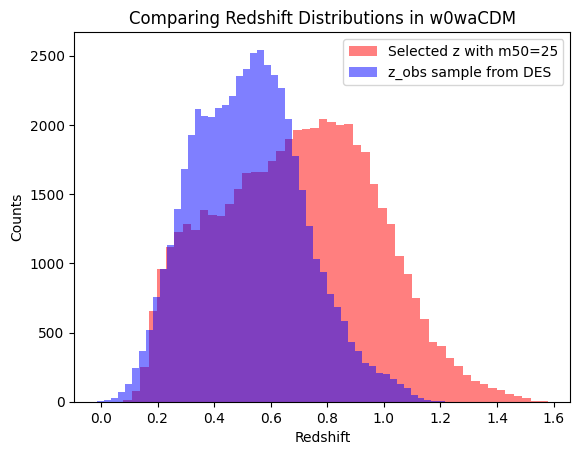

In [14]:
# making sure the redshift bins are correct

kde_z_obs = gaussian_kde(z_obs) # gives the pdf of z obs
z_obs_sample = kde_z_obs.resample(len(z_sim_selected)).flatten() # creates a sample

#plt.hist(sampled_z, bins=50, alpha=0.5, label='True z')
plt.hist(z_sim_selected, bins=50, alpha=0.5, label='Selected z with m50=25', color='red')
plt.hist(z_obs_sample, bins = 50, alpha=0.5, label='z_obs sample from DES', color='blue')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.title("Comparing Redshift Distributions in w0waCDM")
plt.legend()
plt.show()

In [15]:
# now we have a list of mu values WITH bias corrections and we want to apply the CORRECT selection function mask onto these values

efficiency_vec2 = logistic_efficiency(appaz_mag, m50=24, k=4.5)
mask2 = np.random.rand(len(appaz_mag)) < efficiency_vec

mu_shifted = mu_obs_sim[mask2] # because we still want the same bias corrections
z_sim_selected2 = sampled_z[mask2]
cutmuerr_sim2 = cutmuerr_sim[mask2]

# checking lengths match up
print(len(mu_shifted))
print(len(z_sim_selected2))
print(len(cutmuerr_sim2))

51723
51723
51723


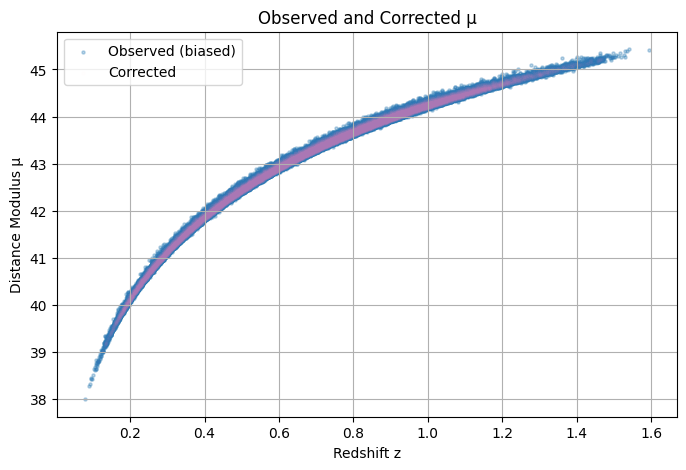

In [16]:
# next, applying the corrections (correction = obs - bias) AFTER inputting correct selection function above

# interpolate to get bias correction for any redshift, not just z bin centre
bias_interp = interp1d(z_bin_centres, bias_vals, kind='linear', bounds_error=False, fill_value=0.0)

mu_bias_applied = bias_interp(z_sim_selected2)  # compute bias per SN
mu_corrected = mu_obs_sim[mask2] - mu_bias_applied # actual correction

# plotting
plt.figure(figsize=(8,5))
plt.scatter(z_sim_selected2, mu_obs_sim[mask2], s=5, alpha=0.3, label='Observed (biased)')
plt.scatter(z_sim_selected2, mu_corrected, s=5, color = 'pink', alpha=0.01, label='Corrected') # can barely see the diff because bias was so small
plt.xlabel('Redshift z')
plt.ylabel('Distance Modulus μ')
plt.legend()
plt.grid(True)
plt.title('Observed and Corrected μ')
plt.show()

In [17]:
# use chi2 to fit to flat LCDM, shouhld optimise well because its the input cosmology

c = 3e5 # km/s
z_star = 1089.95 # redshift of last scattering

#cmbR prior values
R_obs = 1.7502
sigma_R = 0.0046

# flat-ΛCDM, fitting for omega_M using eqn from table 1
def E(z, OmegaM):
    hubble_param = np.sqrt(OmegaM * (1 + z)**3 + (1 - OmegaM))
    return hubble_param

# comoving distance
def comoving_distance(z, OmegaM, H0):
    integrand = lambda z_: 1.0 / E(z_, OmegaM)
    integral, _ = quad(integrand, 0, z)
    return (c / H0) * integral

# defining R_model to add CMB-R as a prior
def R_model(OmegaM, H0):
    D_M = comoving_distance(z_star, OmegaM, H0)
    return np.sqrt(OmegaM) * H0 * D_M / c

# theoretical distance modulus
def mu_theoretical(OmegaM, H0, z):
  dL = (1+z) * (comoving_distance(z, OmegaM, H0)) # changed z_obs to z
  mu = 5* np.log10(dL) + 25 # theoretical mu
  return mu

def chi2(params):
  OmegaM, H0 = params
  # supernova chi2
  mu_model = np.array([mu_theoretical(OmegaM, H0, z) for z in z_sim_selected2])
  dmu = mu_shifted - mu_model # residuals = observed mu - theoretical mu
  chi2_SN = np.sum((dmu / cutmuerr_sim2)**2)

  # CMB-R chi2
  R_true = R_model(OmegaM, H0)
  chi2_CMB = ((R_true - R_obs) / sigma_R)**2
  return chi2_SN + chi2_CMB

initial_guess = [0.3, 50.0]  # OmegaM, H0 (H0 in km/s/Mpc)
result = minimize(chi2, x0 = initial_guess, method='nelder-mead')

print("Optimisation Results:")
print(f"OmegaM = {result.x[0]:.4f}")
print(f"H0 = {result.x[1]:.4f} km/s/Mpc")
print(f"Minimum chi-squared = {result.fun:.2f}")

Optimisation Results:
OmegaM = 0.3533
H0 = 64.1059 km/s/Mpc
Minimum chi-squared = 4869.98


In [18]:
# Flat-wCDM model

# setting H0 and minimising over other parameters
# H0 = 69.3691 # km/s/Mpc

def E(z, OmegaM, w):
    return np.sqrt(OmegaM * (1 + z)**3 + (1 - OmegaM) * (1 + z)**(3 * (1 + w)))

# comoving distance
def comoving_distance(z, OmegaM, w, H0):
    integrand = lambda z_: 1.0 / E(z_, OmegaM, w)
    integral, _ = quad(integrand, 0, z)
    return (c / H0) * integral

# defining R_model to add CMB-R as a prior
def R_model(OmegaM, w, H0):
    D_M = comoving_distance(z_star, OmegaM, w, H0)
    return np.sqrt(OmegaM) * H0 * D_M / c

# theoretical distance modulus
def mu_theoretical(OmegaM, w, H0, z):
    dL = (1 + z) * comoving_distance(z, OmegaM, w, H0)
    return 5 * np.log10(dL) + 25

def chi2(params):
    OmegaM, w, H0 = params
    mu_model = np.array([mu_theoretical(OmegaM, w, H0, z) for z in z_sim_selected2])
    dmu = mu_shifted - mu_model # residuals = observed mu - theoretical mu
    chi2_SN = np.sum((dmu / cutmuerr_sim2)**2)

    # CMB-R chi2
    R_true = R_model(OmegaM, w, H0)
    chi2_CMB = ((R_true - R_obs) / sigma_R)**2
    return chi2_SN + chi2_CMB

initial_guess = [0.3, -1.0, 50]  # OmegaM, w, H0
result2 = minimize(chi2, x0=initial_guess, method='nelder-mead')

print("Optimisation Results:")
print(f"OmegaM = {result2.x[0]:.2f}")
print(f"w = {result2.x[1]:.4f}")
print(f"H0 = {result2.x[2]:.4f} km/s/Mpc")
print(f"Minimum chi-squared = {result2.fun:.2f}")

Optimisation Results:
OmegaM = 0.37
w = -1.1084
H0 = 64.6534 km/s/Mpc
Minimum chi-squared = 4853.01


In [19]:
# Flat-w0waCDM model

def E(z, OmegaM, w0, wa):
    exponent = -3 * wa * z / (1 + z)
    return np.sqrt(OmegaM * (1 + z)**3 + (1 - OmegaM) * (1 + z)**(3 * (1 + w0 + wa)) * np.exp(exponent))

# comoving distance
def comoving_distance(z, OmegaM, w0, wa, H0):
    integrand = lambda z_: 1.0 / E(z_, OmegaM, w0, wa)
    integral, _ = quad(integrand, 0, z)
    return (c / H0) * integral

# defining R_model to add CMB-R as a prior
def R_model(OmegaM, w0, wa, H0):
    D_M = comoving_distance(z_star, OmegaM, w0, wa, H0)
    return np.sqrt(OmegaM) * H0 * D_M / c

def mu_theoretical(OmegaM, w0, wa, H0, z):
    dL = (1 + z) * comoving_distance(z, OmegaM, w0, wa, H0)
    return 5 * np.log10(dL) + 25

def chi2(params):
    OmegaM, w0, wa, H0 = params
    mu_model = np.array([mu_theoretical(OmegaM, w0, wa, H0, z) for z in z_sim_selected2])
    dmu = mu_shifted - mu_model # residuals = observed mu - theoretical mu
    chi2_SN = np.sum((dmu / cutmuerr_sim2)**2)

    # CMB-R chi2
    R_true = R_model(OmegaM, w0, wa, H0)
    chi2_CMB = ((R_true - R_obs) / sigma_R)**2
    return chi2_SN + chi2_CMB

initial_guess = [0.3, -0.3, -8, 50.0]  # OmegaM, w0, wa, H0
result3 = minimize(chi2, x0=initial_guess, method='nelder-mead')

print("Optimisation Results:")
print(f"OmegaM = {result3.x[0]:.2f}")
print(f"w0 = {result3.x[1]:.4f}")
print(f"wa = {result3.x[2]:.4f}")
print(f"H0 = {result3.x[3]:.4f} km/s/Mpc")
print(f"Minimum chi-squared = {result3.fun:.2f}")

Optimisation Results:
OmegaM = 0.36
w0 = -1.7919
wa = 2.1102
H0 = 68.0269 km/s/Mpc
Minimum chi-squared = 4576.28


In [20]:
import scipy
from scipy.stats import norm

# LCDM vs w0waCDM

delta_chi2 = result.fun - result3.fun # always do simpler model - complexer model
dof = 2 # difference in number of params between models

p_value = 1 - scipy.stats.chi2.cdf(delta_chi2, dof)

sigma = norm.ppf(1 - p_value/2)
print("Two-tailed p-value:", p_value)
print("Significance level (σ):", sigma)

Two-tailed p-value: 0.0
Significance level (σ): inf


In [21]:
# LCDM vs wCDM

delta_chi2 = result.fun - result2.fun # always do simpler model - complexer model
dof = 1 # difference in number of params between models

p_value = 1 - scipy.stats.chi2.cdf(delta_chi2, dof)

sigma = norm.ppf(1 - p_value/2)
print("Two-tailed p-value:", p_value)
print("Significance level (σ):", sigma)

Two-tailed p-value: 3.800788460772697e-05
Significance level (σ): 4.119267417048342


In [22]:
# wCDM vs w0waCDM

delta_chi2 = result2.fun - result3.fun # always do simpler model - complexer model
dof = 1 # difference in number of params between models

p_value = 1 - scipy.stats.chi2.cdf(delta_chi2, dof)

sigma = norm.ppf(1 - p_value/2)
print("Two-tailed p-value:", p_value)
print("Significance level (σ):", sigma)

Two-tailed p-value: 0.0
Significance level (σ): inf
